In [1]:
import requests
import torch
from PIL import Image
from io import BytesIO
from torchvision import transforms as tfms
import omegaconf
import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
import autocast

from diffusers import StableDiffusionImg2ImgPipeline, AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from diffusers.utils import load_image

In [6]:
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline
from diffusers.utils import load_image

device = "mps"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

img = load_image("german_road.jpg")
init_image = img.resize((768, 512))

prompt = "forest everywhere"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
images[0].save("fantasy_landscape.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

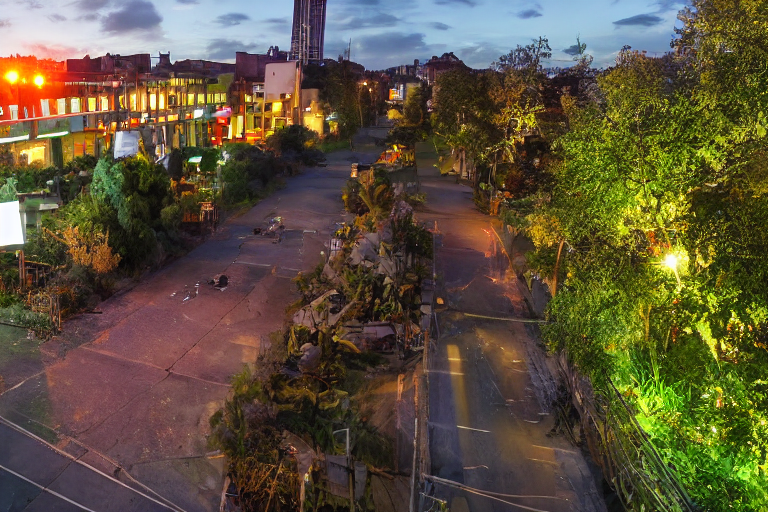

In [7]:
img = load_image("german_road.jpg")
init_image = img.resize((768, 512))

prompt = "night time"

image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images[0]
image

In [2]:
from diffusers import AutoencoderKL

url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"  # can also be local file
vae = AutoencoderKL.from_single_file(url)
vae = vae.to("mps")

In [3]:
# Using torchvision.transforms.ToTensor
to_tensor_tfm = tfms.ToTensor()

def pil_to_latent(input_im):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
    latent = vae.encode(to_tensor_tfm(input_im).unsqueeze(0).to("mps")*2-1) # Note scaling
  return 0.18215 * latent[0].mode() # or .mean or .sample

def latents_to_pil(latents):
  # bath of latents -> list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents)[0]
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

AutoencoderKLOutput(latent_dist=<diffusers.models.vae.DiagonalGaussianDistribution object at 0x110490a30>) other <diffusers.models.vae.DiagonalGaussianDistribution object at 0x110490a30>


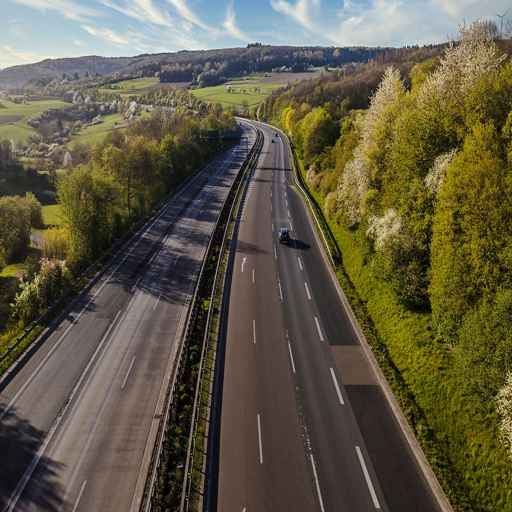

In [12]:
im = Image.open('german_road.jpg')
im = im.resize((512,512))
encoded = pil_to_latent(im)
im

In [4]:
# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [5]:
# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.pre_layrnorm.bias', 'vision_model.encoder.layers.11.layer_norm1.weight', 'vision_model.encoder.layers.12.layer_norm1.weight', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.15.self_attn.out_proj.bias', 'vision_model.encoder.layers.15.layer_norm1.bias', 'vision_model.encoder.layers.4.layer_norm1.bias', 'vision_model.encoder.layers.1.mlp.fc2.bias', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.15.mlp.fc1.bias', 'vision_model.encoder.layers.2.mlp.fc2.bias', 'vision_model.encoder.layers.8.layer_norm1.bias', 'vision_model.encoder.layers.22.self_attn.k_proj.weight', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.5.layer_norm1.bias', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layer

In [7]:
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

In [10]:
prompt = ["smooth roads in the night time"]
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids)[0]

In [12]:
prompt = ["smooth roads in the night time"]
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(1)
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids)[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids)[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Start step
start_step = 25
start_sigma = scheduler.sigmas[start_step]
start_timestep = int(scheduler.timesteps[start_step])

# Prep latents
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, start_timestep)
latents = latents.to("mps")
latents = latents * start_sigma  # << NB

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i > start_step:
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]

RuntimeError: Placeholder storage has not been allocated on MPS device!